In [151]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected
from tensorflow.contrib.framework.python.ops import add_arg_scope, arg_scope, arg_scoped_arguments
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, fbeta_score, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
f_half_scorer = make_scorer(fbeta_score, beta=0.5)

%matplotlib inline

# Load and clean the data

In [ ]:
df = pd.read_csv('data/OH.csv')

### These are the columns that will be used in the model

In [ ]:
workable_cols = ['stop_date','stop_time','location_raw','driver_gender','driver_race','driver_race_raw','violation',
                 'search_conducted','contraband_found','is_arrested','drugs_related_stop']

df_reduced = df[workable_cols].copy()

### Convert time into hours and date into month

In [ ]:
df_reduced['stop_hour'] = df_reduced['stop_time'].apply(lambda x: x.split(':')[0])
df_reduced['stop_month'] = df_reduced['stop_date'].apply(lambda x: x.split('-')[1])
df_reduced.drop('stop_time',axis=1,inplace=True)
df_reduced.drop('stop_date',axis=1,inplace=True)

### Save the 20 most frequent locations, which account for ~90% of all the locations. The remainder is set to null, to be imputed later

In [ ]:
print(df_reduced['location_raw'].value_counts()[:20].sum()/df_reduced.shape[0])
keep_locations = list(df_reduced['location_raw'].value_counts().keys()[:20])
df_reduced['location_raw'] = df_reduced['location_raw'].apply(lambda x: int(x) if x in keep_locations else None)

### There are two columns for driver race. Impute the 'other' values in one, with the values from the other

In [ ]:
df_reduced['driver_race'].loc[df_reduced['driver_race']=='Other'] = df_reduced['driver_race_raw'].loc[df_reduced['driver_race']=='Other']
#df_reduced['driver_race'] = df_reduced.apply(lambda x: x['driver_race_raw'] if x['driver_race'] == 'Other' else x['driver_race'],axis=1)
df_reduced.drop('driver_race_raw',axis=1,inplace=True)

### There is a realtively small number of unique violations

In [ ]:
violations_unique = []
for l in df_reduced['violation'].dropna().unique():
    violations_unique = violations_unique + l.lower().split(',')
violations_unique = set(violations_unique)
print(violations_unique)

### Create a mapping between violations to integer values, which are ranked from worst to least
### The worst one will be selected in each row

In [ ]:
def violations_denoter(x):
    
    violations_severity = {
        'dui':0,
        'speeding':1,
        'stop sign/light':2,
        'license':3,
        'cell phone':4,
        'paperwork':5,
        'registration/plates':6,
        'safe movement':7,
        'seat belt':8,    
        'equipment':9,
        'lights':10,
        'truck':11,
        'other':12,
        'other (non-mapped)':13
    }
    
    violations = []
    for k,v in violations_severity.items():
        if (k in x.lower()):
            violations.append(v)
            
    return min(violations)

In [ ]:
df_reduced['violations_numbered'] = df_reduced['violation'].fillna('other (non-mapped)').apply(violations_denoter)
df_reduced.drop('violation',axis=1,inplace=True)

In [ ]:
categorical = list(df_reduced.columns)
categorical.remove('is_arrested')

In [ ]:
def replace_na_categorical(df,column):

    prob = dict(df[column].value_counts()/len(df))
    
    keys = list(prob.keys())
    
    sum_prob = sum(prob.values())

    for k,v in prob.items():
        prob[k] = prob[k]/sum_prob

    prob_list = list(prob.values())

    to_fillin = np.random.choice(keys, len(df[column].loc[df[column].isnull()]), p = prob_list)
    
    df[column].loc[df[column].isnull()] = to_fillin
    
    return df

In [ ]:
for c in categorical:
    df_reduced = replace_na_categorical(df_reduced,c)

In [ ]:
dummy = pd.get_dummies(df_reduced,columns=categorical)
dummy.to_csv('data/df_cleaned.csv',index=False)
dummy_sampled = dummy.sample(frac=0.1,random_state=2018).reset_index(drop=True)
dummy_sampled.to_csv('data/df_sampled_cleaned.csv',index=False)

## Set up the model training and testing

In [25]:
def run_HPS_search(train_X,train_Y,model,n_iter,score,cv,weights=None):
    
    model_selection, params = get_model_and_params(model)
    
    RS = RandomizedSearchCV(model_selection,param_distributions=params,n_iter=n_iter,scoring=score,cv=cv,error_score='0')
    RS.fit(train_X,train_Y,sample_weight=weights)
    print("Best params - ", RS.best_params_)
    print("Highest %s = %s"%(score,RS.best_score_))
    
    return RS.best_estimator_

In [26]:
def get_model_and_params(model):
    
    model_selection = {
        'RFC':RandomForestClassifier(),
        'GBC':GradientBoostingClassifier(),
        'LR':LogisticRegression()
    }
    
    model_hyperparameters = {
        'RFC':{
            'n_estimators':range(1,101),
            'max_depth':range(1,50),
            'n_jobs':[-1],
            'criterion':['gini','entropy'],
            'class_weight':[None]
        },
        'GBC':{
            'loss':['deviance','exponential'],
            'learning_rate':10**np.linspace(-4,-1,10),
            'n_estimators':range(50,150)
        },
        'LR':{
            'C':10.**np.linspace(-3,3,20),
            'tol':10**np.linspace(-5,-1,20),
            'penalty':['l2'],
            'class_weight':['balanced']
        }
    }
    
    return model_selection[model], model_hyperparameters[model]

In [27]:
def run_clf(model,train_X,train_Y,params,weights=None):
    
    clf = get_model_and_params(model)[0]
    
    clf.set_params(**params)
    clf.fit(train_X,train_Y,sample_weight=weights)
    
    return clf

In [107]:
def check_error_and_discrimination(clf,test_X,test_Y,df_test,sensitive_features):

    Y_predict = clf.predict(test_X)

    print("F1 score = %s" %f1_score(test_Y,Y_predict))
    print("Precision score = %s" %precision_score(test_Y,Y_predict))
    print("Recall score = %s" %recall_score(test_Y,Y_predict))
    print("Accuracy score = %s" %accuracy_score(test_Y,Y_predict))

    print()

    s = np.asarray(df_test[sensitive_features])
    print("Discrimination_ratio = %s" %(discrimination(np.expand_dims(Y_predict,1),s)))

    print()

    features = ['driver_race_Asian','driver_race_Black','driver_race_White','driver_race_Hispanic']
    
    bias = [
    features,
    list(df_test[features].mean()),
    list(df_test[features].loc[Y_predict==1].mean()),
    list(df_test[features].loc[Y_predict==0].mean())
    ]
        
    return bias

In [111]:
def discrimination(y,s):
    
    P_a1_s1 = float(y[s==1].sum())/float(len(s[s==1]))
    P_a1_s0 = float(y[s==0].sum())/float(len(s[s==0]))
    
    disc_ratio =  P_a1_s1/P_a1_s0
    
    return disc_ratio

In [30]:
def balance_df(df,f_balance):
    
    if (f_balance == -1):
        return df
    
    cond = df['is_arrested']==True

    df_balanced = pd.concat(
        [df.loc[cond],
         df.loc[~cond].sample(n=df.loc[cond].shape[0]*f_balance)],
        axis=0
    ).sample(frac=1).reset_index(drop=True)
    
    return df_balanced

In [126]:
def plot_distribution(df_bias):
    iai_colors = {
        'blue': np.array([72, 196, 217]) / 255,
        'ruby': np.array([240, 86, 60]) / 255,
        'grey': np.array([49, 64, 73]) / 255,
        'beige': np.array([241, 231, 220]) / 255
    }

    plt.bar(np.arange(df_bias.shape[0])-0.2,df_bias['N_group/N_total']*100,0.2,color=iai_colors['grey'])
    plt.bar(np.arange(df_bias.shape[0]),df_bias['N_group/N_total|(predicted arrest)']*100,0.2,color=iai_colors['ruby'])
    plt.bar(np.arange(df_bias.shape[0])+0.2,df_bias['N_group/N_total|(predicted not arrest)']*100,0.2,color=iai_colors['blue'])
    plt.xticks(np.arange(df_bias.shape[0]),('Asian','Black','White','Hispanic'))
    plt.ylabel('% of people in each group')
    plt.ylim([0,100])
    plt.legend(['Overall','Predicted arrested','Predicted not arrested'])
    plt.show()

In [223]:
df = pd.read_csv('data/df_sampled_cleaned.csv')

In [123]:
df_train, df_test = train_test_split(df,test_size=0.3)

In [94]:
target_feature = 'is_arrested'
sensitive_features = ['driver_race_Black']

In [124]:
train_X = np.asarray(df_train.drop([target_feature],axis=1))
train_Y = np.asarray(df_train[target_feature]).astype(int)

test_X = np.asarray(df_test.drop([target_feature],axis=1))
test_Y = np.asarray(df_test[target_feature]).astype(int)

F1 score = 0.21681723419
Precision score = 0.555160142349
Recall score = 0.134715025907
Accuracy score = 0.993907449454

Discrimination_ratio = 3.256294240669241



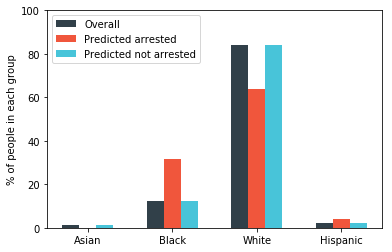

In [127]:
params = {'n_jobs': -1, 'n_estimators': 47, 'max_depth': 8, 'criterion': 'gini', 'class_weight': None}
weights = np.ones(train_Y.shape[0])
weights[train_Y==1] = 1.
weights[train_Y==0] = 0.5
RFC = run_clf('RFC',train_X,train_Y,params,weights=weights)
bias = check_error_and_discrimination(RFC,test_X,test_Y,df_test,sensitive_features)
df_bias = pd.DataFrame(bias).transpose()
df_bias.columns = ["Group","N_group/N_total","N_group/N_total|(predicted arrest)","N_group/N_total|(predicted not arrest)"]
plot_distribution(df_bias)

## Begin setting up the VFAE

In [10]:
def gen_weights_biases(shape):
    return tf.Variable(tf.random_normal(shape, stddev=tf.sqrt(0.5 / float(shape[0]))))

In [11]:
def activate(x,activation):
    if (activation == 'relu'):
        return tf.nn.relu(x)
    elif (activation == 'sigmoid'):
        return tf.nn.sigmoid(x)
    elif (activation == 'tanh'):
        return tf.nn.tanh(x)
    elif (activation == 'softmax'):
        return tf.nn.softmax(x)
    elif (activation == 'linear'):
        return x

In [12]:
def get_batch(list_arrays,batch_size,index_shuffled,b):
    
    return [x[index_shuffled[b*batch_size:(b+1)*batch_size]] for x in list_arrays]

In [250]:
def initialize_params(dims,N_epochs=1000,print_freq=100,batch_size=100,lr=1e-3,alpha=1.,beta=1.,D=500,gamma=1.):

    params = {
        'enc1':{
            'in_dim':dims['x']+dims['s'],
            'hid_dim':dims['enc1_hid'],
            'out_dim':dims['z1'],
            'act':{
                'hid':'relu',
                'mu':'linear',
                'log_sigma':'linear'
            }
        },   
        'enc2':{
            'in_dim':dims['z1']+1,
            'hid_dim':dims['enc2_hid'],
            'out_dim':dims['z2'],
            'act':{
                'hid':'relu',
                'mu':'linear',
                'log_sigma':'linear'
            }
        },
        'dec1':{
            'in_dim':dims['z2']+1,
            'hid_dim':dims['dec1_hid'],
            'out_dim':dims['z1'],
            'act':{
                'hid':'relu',
                'mu':'linear',
                'log_sigma':'linear'
            }
        },
        'dec2':{
            'in_dim':dims['z1']+dims['s'],
            'hid_dim':dims['dec2_hid'],
            'out_dim':dims['x']+dims['s'],
            'act':{
                'hid':'relu',
                'mu':'sigmoid',
                'log_sigma':'sigmoid',
                'bernoulli':'sigmoid'
            }
        },
        'us':{
            'in_dim':dims['z1'],
            'hid_dim':dims['us_hid'],
            'out_dim':dims['y_cat'],
            'act':{
                'hid':'relu',
                'out':'softmax'
            }
        },
        'N_epochs':N_epochs,
        'print_frequency':print_freq,
        'batch_size':batch_size,
        'lr':lr,
        'alpha':alpha,
        'beta':beta,
        'D':D,
        'gamma':gamma
    }
    
    return params

In [14]:
def initialize_weights_biases(params):

    weights = {
        'enc1':{
            'hid':gen_weights_biases([params['enc1']['in_dim'],params['enc1']['hid_dim']]),
            'mu':gen_weights_biases([params['enc1']['hid_dim'],params['enc1']['out_dim']]),
            'log_sigma':gen_weights_biases([params['enc1']['hid_dim'],params['enc1']['out_dim']])
        },
        'enc2':{
            'hid':gen_weights_biases([params['enc2']['in_dim'],params['enc2']['hid_dim']]),
            'mu':gen_weights_biases([params['enc2']['hid_dim'],params['enc2']['out_dim']]),
            'log_sigma':gen_weights_biases([params['enc2']['hid_dim'],params['enc2']['out_dim']])
        },
        'dec1':{
            'hid':gen_weights_biases([params['dec1']['in_dim'],params['dec1']['hid_dim']]),
            'mu':gen_weights_biases([params['dec1']['hid_dim'],params['dec1']['out_dim']]),
            'log_sigma':gen_weights_biases([params['dec1']['hid_dim'],params['dec1']['out_dim']])
        },
        'dec2':{
            'hid':gen_weights_biases([params['dec2']['in_dim'],params['dec2']['hid_dim']]),
            'mu':gen_weights_biases([params['dec2']['hid_dim'],params['dec2']['out_dim']]),
            'log_sigma':gen_weights_biases([params['dec2']['hid_dim'],params['dec2']['out_dim']])
        },
        'us':{
            'hid':gen_weights_biases([params['us']['in_dim'],params['us']['hid_dim']]),
            'mu':gen_weights_biases([params['us']['hid_dim'],params['us']['out_dim']]),
            'log_sigma':gen_weights_biases([params['us']['hid_dim'],params['us']['out_dim']])
        }       
    }

    bias = {
        'enc1':{
            'hid':gen_weights_biases([params['enc1']['hid_dim']]),
            'mu':gen_weights_biases([params['enc1']['out_dim']]),
            'log_sigma':gen_weights_biases([params['enc1']['out_dim']])
        },
        'enc2':{
            'hid':gen_weights_biases([params['enc2']['hid_dim']]),
            'mu':gen_weights_biases([params['enc2']['out_dim']]),
            'log_sigma':gen_weights_biases([params['enc2']['out_dim']])
        },
        'dec1':{
            'hid':gen_weights_biases([params['dec1']['hid_dim']]),
            'mu':gen_weights_biases([params['dec1']['out_dim']]),
            'log_sigma':gen_weights_biases([params['dec1']['out_dim']])
        },
        'dec2':{
            'hid':gen_weights_biases([params['dec2']['hid_dim']]),
            'mu':gen_weights_biases([params['dec2']['out_dim']]),
            'log_sigma':gen_weights_biases([params['dec2']['out_dim']])
        },
        'us':{
            'hid':gen_weights_biases([params['us']['hid_dim']]),
            'mu':gen_weights_biases([params['us']['out_dim']]),
            'log_sigma':gen_weights_biases([params['us']['out_dim']])
        }
    }
    
    return weights, bias

In [163]:
def MLP(x_in,weights,bias,activation,epsilon):
    
    hidden = activate(tf.matmul(x_in,weights['hid'])+bias['hid'],activation['hid'])

    mu = activate(tf.matmul(hidden,weights['mu'])+bias['mu'],activation['mu'])

    log_sigma = activate(tf.matmul(hidden,weights['log_sigma'])+bias['log_sigma'],activation['log_sigma'])

    return mu + tf.exp(log_sigma / 2) * epsilon, mu, log_sigma

In [67]:
def KL(mu1,log_sigma_sq1,mu2=0.,log_sigma_sq2=0.):
    return 0.5*tf.reduce_sum(log_sigma_sq2-log_sigma_sq1-1+(tf.exp(log_sigma_sq1)+tf.pow(mu1-mu2,2))/tf.exp(log_sigma_sq2),axis=1)

In [17]:
def LH(x,mu,log_sigma):
    return 0.5 * tf.reduce_sum(np.log(2 * np.pi) + log_sigma + tf.pow(x - mu,2) / tf.exp(log_sigma), axis=1)

In [157]:
def fast_MMD(x1,x2,params):
    inner_difference = tf.reduce_mean(psi(x1,params),axis=0) - tf.reduce_mean(psi(x2,params),axis=0)
    return tf.tensordot(inner_difference,inner_difference,axes=1)

In [164]:
def psi(x,params):
    W = tf.Variable(tf.random_normal([params['enc1']['out_dim'],params['D']], 
                         stddev=tf.sqrt(0.5 / float(params['enc1']['out_dim'])),
                         dtype=tf.float32))
    b = tf.Variable(tf.random_uniform([params['D']],0,2*np.pi,dtype=tf.float32))
    
    return tf.pow(2./params['D'],0.5)*tf.cos(tf.pow(2./params['gamma'],0.5)*tf.matmul(x,W) + b)

In [198]:
def train_VFAE(train_X,train_Y,train_s,test_X,test_Y,test_s,weights,bias,params,dims):

    x = tf.placeholder(tf.float32,shape=[None,dims['x']],name='x')
    s = tf.placeholder(tf.float32,shape=[None,dims['s']],name='s')
    y = tf.placeholder(tf.float32,shape=[None,1],name='y')
    
    epsilon0 = tf.random_normal([params['enc1']['out_dim']], dtype=tf.float32, name='epsilon0')
    z1_enc, z1_enc_mu, z1_enc_log_sigma = MLP(tf.concat([x,s],axis=1),weights['enc1'],bias['enc1'],params['enc1']['act'],epsilon0)
    
    epsilon1 = tf.random_normal([params['enc2']['out_dim']], dtype=tf.float32, name='epsilon1')
    z2_enc, z2_enc_mu, z2_enc_log_sigma = MLP(tf.concat([z1_enc,y],axis=1),weights['enc2'],bias['enc2'],params['enc2']['act'],epsilon1)
    
    epsilon2 = tf.random_normal([params['dec1']['out_dim']], dtype=tf.float32, name='epsilon2')
    z1_dec, z1_dec_mu, z1_dec_log_sigma = MLP(tf.concat([z2_enc,y],axis=1),weights['dec1'],bias['dec1'],params['dec1']['act'],epsilon2)
    
    epsilon3 = tf.zeros([params['dec2']['out_dim']], dtype=tf.float32, name='epsilon3')
    x_out = MLP(tf.concat([z1_dec,s],axis=1),weights['dec2'],bias['dec2'],params['dec2']['act'],epsilon3)[0]

    epsilon4 = tf.zeros([params['us']['out_dim']], dtype=tf.float32, name='epsilon4')
    y_us = MLP(z1_enc,weights['us'],bias['us'],params['us']['act'],epsilon4)[0]
    
    KL_z1 = KL(z1_enc_mu,z1_enc_log_sigma,z1_dec_mu,z1_dec_log_sigma)
    KL_z2 = KL(z2_enc_mu,z2_enc_log_sigma)
    
    LH_x = tf.reduce_sum(tf.concat([x,s],axis=1) * tf.log(1e-10+x_out) + (1 - tf.concat([x,s],axis=1)) * tf.log(1e-10+1 - x_out),axis=1)
    
    index = tf.range(tf.shape(y)[0])
        
    idx = tf.stack([index[:, tf.newaxis], tf.cast(y,tf.int32)], axis=-1)
    
    LH_y = tf.reduce_sum(tf.log(1e-10+tf.gather_nd(y_us, idx)),axis=1)

    MMD_x1 = tf.boolean_mask(z1_enc,tf.tile(tf.cast(s,tf.bool),[1,tf.shape(z1_enc)[1]]))
    MMD_x2 = tf.boolean_mask(z1_enc,tf.tile(tf.cast(1-s,tf.bool),[1,tf.shape(z1_enc)[1]]))
    MMD = fast_MMD(tf.reshape(MMD_x1,[tf.cast(tf.shape(MMD_x1)[0]/tf.shape(z1_enc)[1],tf.int32),tf.shape(z1_enc)[1]]),
                   tf.reshape(MMD_x2,[tf.cast(tf.shape(MMD_x2)[0]/tf.shape(z1_enc)[1],tf.int32),tf.shape(z1_enc)[1]]),
                  params)

    loss = -(-tf.reduce_mean(KL_z1)-tf.reduce_mean(KL_z2)+tf.reduce_mean(LH_x) - params['alpha']*tf.reduce_mean(LH_y) - params['beta']*MMD)

    optimizer = tf.train.AdamOptimizer(learning_rate=params['lr'])

    train = optimizer.minimize(loss)

    sess = tf.Session()

    sess.run(tf.global_variables_initializer())
    
    index_shuffled = np.arange(train_X.shape[0])
    np.random.shuffle(index_shuffled)

    N_batches = int(float(train_X.shape[0])/float(params['batch_size']))
    
    for i in range(params['N_epochs']):
        
        for b in range(N_batches):
            
            batch_X, batch_Y, batch_s = get_batch([train_X,train_Y,train_s],params['batch_size'],index_shuffled,b)

            batch_dict = {x:batch_X,y:batch_Y,s:batch_s}
            full_dict = {x:train_X,y:train_Y,s:train_s}

            sess.run(train,feed_dict=batch_dict)

        if (i % params['print_frequency'] == 0 or i == params['N_epochs']-1):

            print("Epoch %s: batch loss = %s and global loss = %s"%(i,
                    sess.run(loss,feed_dict=batch_dict),
                    sess.run(loss,feed_dict=full_dict)))
            print("KL_z1 = %s, KL_z2 = %s, RL = %s, unsupervised posterior = %s, MMD = %s" \
                  %sess.run((tf.reduce_mean(KL_z1),
                             tf.reduce_mean(KL_z2),
                             tf.reduce_mean(LH_x),
                             tf.reduce_mean(LH_y),
                             params['beta']*MMD
                            ),
                            feed_dict=batch_dict))
            
    test_dict = {x:test_X,y:test_Y,s:test_s}
    return sess.run([x_out,z1_enc,loss,tf.reduce_mean(LH_x)],feed_dict=test_dict)

### Split the dataset into a training and cross-validation sets, to determine the optimal hyperparameters for the VFAE

In [21]:
def obtain_X_Y_s(df,target_feature,sensitive_features):
    
    X = np.asarray(df.drop([target_feature]+sensitive_features,axis=1))
    Y = np.expand_dims(np.asarray(df[target_feature]).astype(int),1)
    s = np.asarray(df[sensitive_features]).astype(int)

    return X, Y, s

In [228]:
df_VFAE_train, df_VFAE_CV = train_test_split(df,test_size=0.5)
df_VFAE_CV, df_VFAE_test = train_test_split(df_VFAE_CV,test_size=0.75)

df_VFAE_train = df_VFAE_train.reset_index(drop=True)
df_VFAE_CV = df_VFAE_CV.reset_index(drop=True)
df_VFAE_test = df_VFAE_test.reset_index(drop=True)

VFAE_train_X, VFAE_train_Y, VFAE_train_s = obtain_X_Y_s(df_VFAE_train,target_feature,sensitive_features)
VFAE_CV_X, VFAE_CV_Y, VFAE_CV_s = obtain_X_Y_s(df_VFAE_CV,target_feature,sensitive_features)
VFAE_test_X, VFAE_test_Y, VFAE_test_s = obtain_X_Y_s(df_VFAE_test,target_feature,sensitive_features)

### Perform a hyperparamter search

In [210]:
tf.reset_default_graph()

# Hidden units in the hidden layers
# [z1, z2, encoding1, encoding2, decoding1, decoding2, unsupervised]
hidden_dim_list = [
    [20,20,50,50,50,50,50]
]

lr_list = [1e-3,1e-2]

alpha_list = [1e-1,1e0,1e1]

batch_size_list = [1000,10000]

beta_list = [1e-1,1e0,1e1]

D_list = [50,100,200]

loss_min = 1e3

for hd in hidden_dim_list:
    
    for lr in lr_list:
        
        for alpha in alpha_list:
            
            for bs in batch_size_list:
                
                for beta in beta_list:
                    
                    for D in D_list:
        
                        print("Begin analysis for dims = %s, lr = %s, alpha = %s, batch size = %s, beta = %s, D = %s:"%(hd,lr,alpha,bs,beta,D))

                        dims = {
                            'x':VFAE_train_X.shape[1],
                            'y_cat':len(np.unique(VFAE_train_Y)),
                            's':VFAE_train_s.shape[1],
                            'z1':hd[0],
                            'z2':hd[1],
                            'enc1_hid':hd[2],
                            'enc2_hid':hd[3],
                            'dec1_hid':hd[4],
                            'dec2_hid':hd[5],
                            'us_hid':hd[6]
                        }

                        params = initialize_params(dims,N_epochs=10,lr=lr,print_freq=5,batch_size=bs,alpha=alpha,beta=beta,D=D,gamma=1)
                        weights, bias = initialize_weights_biases(params)
                        enc_X, latent_X, loss, LH_x = train_VFAE(VFAE_train_X,VFAE_train_Y,VFAE_train_s,VFAE_CV_X,VFAE_CV_Y,VFAE_CV_s,weights,bias,params,dims)

                        print("The CV global loss = %s and reconstruction loss and = %s"%(loss,LH_x))
                        print()
                        print()

                        if (np.abs(LH_x) < loss_min):
                            loss_min = np.abs(LH_x)
                            d_optimal = hd
                            lr_optimal = lr
                            alpha_optimal = alpha
                            bs_optimal = bs
                            beta_optimal = beta
                            D_optimal = D
                            latent_X_optimal = latent_X
                    
print("The minimum loss of %s was obtained using dims = %s, lr = %s, alpha = %s, bs = %s, beta = %s, D = %s"%(loss_min,d_optimal,lr_optimal,alpha_optimal,bs_optimal,beta_optimal,D_optimal))            

Begin analysis for dims = [20, 20, 50, 50, 50, 50, 50], lr = 0.001, alpha = 0.1, batch size = 1000, beta = 0.1, D = 50:


/Users/yevgenik/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 0: batch loss = 15.063 and global loss = 15.0794
KL_z1 = 1.40626, KL_z2 = 0.270414, RL = -18.605, unsupervised posterior = -22.8647, MMD = 0.105036
Epoch 5: batch loss = 13.9147 and global loss = 14.1827
KL_z1 = 0.161108, KL_z2 = 0.0160111, RL = -16.0559, unsupervised posterior = -22.8647, MMD = 0.00327136
The CV global loss and reconstruction loss = 13.3014 and -15.4828


Begin analysis for dims = [20, 20, 50, 50, 50, 50, 50], lr = 0.001, alpha = 0.1, batch size = 1000, beta = 0.1, D = 100:
Epoch 0: batch loss = 15.5433 and global loss = 18.3853
KL_z1 = 1.06085, KL_z2 = 0.503575, RL = -16.7037, unsupervised posterior = -22.7956, MMD = 0.0967684
Epoch 5: batch loss = 13.6276 and global loss = 13.5029
KL_z1 = 0.304481, KL_z2 = 0.0489052, RL = -15.6321, unsupervised posterior = -22.7956, MMD = 0.00715224
The CV global loss and reconstruction loss = 13.2092 and -15.4441


Begin analysis for dims = [20, 20, 50, 50, 50, 50, 50], lr = 0.001, alpha = 0.1, batch size = 1000, beta = 0.1, 

KL_z1 = 2.29597, KL_z2 = 0.322634, RL = -18.2406, unsupervised posterior = -21.4258, MMD = 6.29572
The CV global loss and reconstruction loss = 19.3614 and -16.9772


Begin analysis for dims = [20, 20, 50, 50, 50, 50, 50], lr = 0.001, alpha = 0.1, batch size = 10000, beta = 10.0, D = 200:
Epoch 0: batch loss = 66.3103 and global loss = 67.0616
KL_z1 = 1.27234, KL_z2 = 2.16611, RL = -45.5891, unsupervised posterior = -1.49463, MMD = 20.184
Epoch 5: batch loss = 26.1406 and global loss = 33.7444
KL_z1 = 2.17268, KL_z2 = 0.360496, RL = -17.3112, unsupervised posterior = -15.8222, MMD = 11.1899
The CV global loss and reconstruction loss = 27.6287 and -18.2112


Begin analysis for dims = [20, 20, 50, 50, 50, 50, 50], lr = 0.001, alpha = 1.0, batch size = 1000, beta = 0.1, D = 50:
Epoch 0: batch loss = -4.26042 and global loss = -4.17417
KL_z1 = 0.776859, KL_z2 = 0.375039, RL = -16.4206, unsupervised posterior = -22.7726, MMD = 0.0992997
Epoch 5: batch loss = -6.92023 and global loss = -6.84

Epoch 0: batch loss = 65.577 and global loss = 68.0063
KL_z1 = 2.76635, KL_z2 = 1.63442, RL = -45.15, unsupervised posterior = -0.492853, MMD = 15.1935
Epoch 5: batch loss = 2.1984 and global loss = 4.6588
KL_z1 = 4.08633, KL_z2 = 0.395608, RL = -17.2317, unsupervised posterior = -22.3897, MMD = 3.29228
The CV global loss and reconstruction loss = -1.08559 and -16.6318


Begin analysis for dims = [20, 20, 50, 50, 50, 50, 50], lr = 0.001, alpha = 1.0, batch size = 10000, beta = 10.0, D = 100:
Epoch 0: batch loss = 66.9316 and global loss = 70.0623
KL_z1 = 3.21174, KL_z2 = 1.30264, RL = -49.3665, unsupervised posterior = -0.646721, MMD = 21.2156
Epoch 5: batch loss = 11.3352 and global loss = 10.1904
KL_z1 = 3.10421, KL_z2 = 1.06255, RL = -17.5737, unsupervised posterior = -22.8958, MMD = 10.8953
The CV global loss and reconstruction loss = 1.97933 and -16.4106


Begin analysis for dims = [20, 20, 50, 50, 50, 50, 50], lr = 0.001, alpha = 1.0, batch size = 10000, beta = 10.0, D = 200:
Epo

Epoch 5: batch loss = -198.242 and global loss = -198.881
KL_z1 = 9.08508, KL_z2 = 3.02341, RL = -17.184, unsupervised posterior = -22.8605, MMD = 1.00402
The CV global loss and reconstruction loss = -208.098 and -16.61


Begin analysis for dims = [20, 20, 50, 50, 50, 50, 50], lr = 0.001, alpha = 10.0, batch size = 10000, beta = 1.0, D = 200:
Epoch 0: batch loss = 34.8989 and global loss = 43.2238
KL_z1 = 1.24602, KL_z2 = 1.75024, RL = -49.1119, unsupervised posterior = -1.82681, MMD = 1.90934
Epoch 5: batch loss = -202.471 and global loss = -200.011
KL_z1 = 4.07635, KL_z2 = 1.80675, RL = -16.4683, unsupervised posterior = -22.8944, MMD = 1.4164
The CV global loss and reconstruction loss = -206.959 and -17.1436


Begin analysis for dims = [20, 20, 50, 50, 50, 50, 50], lr = 0.001, alpha = 10.0, batch size = 10000, beta = 10.0, D = 50:
Epoch 0: batch loss = 62.2761 and global loss = 58.96
KL_z1 = 2.13182, KL_z2 = 1.43506, RL = -46.3055, unsupervised posterior = -1.68963, MMD = 16.6837
Ep

The CV global loss and reconstruction loss = 13.609 and -15.6428


Begin analysis for dims = [20, 20, 50, 50, 50, 50, 50], lr = 0.01, alpha = 0.1, batch size = 10000, beta = 1.0, D = 50:
Epoch 0: batch loss = 20.6911 and global loss = 18.806
KL_z1 = 2.16682, KL_z2 = 1.25469, RL = -17.6142, unsupervised posterior = -22.9041, MMD = 2.03684
Epoch 5: batch loss = 13.9331 and global loss = 15.1147
KL_z1 = 0.279875, KL_z2 = 0.0219235, RL = -15.556, unsupervised posterior = -22.9066, MMD = 0.233791
The CV global loss and reconstruction loss = 13.6264 and -15.5034


Begin analysis for dims = [20, 20, 50, 50, 50, 50, 50], lr = 0.01, alpha = 0.1, batch size = 10000, beta = 1.0, D = 100:
Epoch 0: batch loss = 20.3178 and global loss = 20.1638
KL_z1 = 1.01897, KL_z2 = 2.83125, RL = -17.0913, unsupervised posterior = -22.8671, MMD = 1.70481
Epoch 5: batch loss = 16.1237 and global loss = 14.6686
KL_z1 = 0.227216, KL_z2 = 0.0508351, RL = -15.9878, unsupervised posterior = -22.8674, MMD = 0.0739456
T

Epoch 0: batch loss = -0.0880454 and global loss = -0.342481
KL_z1 = 3.78462, KL_z2 = 1.9759, RL = -18.7131, unsupervised posterior = -22.8839, MMD = 0.10516
Epoch 5: batch loss = -5.25044 and global loss = -6.1226
KL_z1 = 0.326463, KL_z2 = 0.0468429, RL = -15.501, unsupervised posterior = -22.8997, MMD = 0.0526171
The CV global loss and reconstruction loss = -7.15823 and -15.5654


Begin analysis for dims = [20, 20, 50, 50, 50, 50, 50], lr = 0.01, alpha = 1.0, batch size = 10000, beta = 0.1, D = 200:
Epoch 0: batch loss = 3.54277 and global loss = -0.0917754
KL_z1 = 1.89419, KL_z2 = 0.345415, RL = -16.8521, unsupervised posterior = -22.8927, MMD = 0.125802
Epoch 5: batch loss = -6.68856 and global loss = -6.41175
KL_z1 = 0.656821, KL_z2 = 0.0241779, RL = -15.637, unsupervised posterior = -22.8927, MMD = 0.0438254
The CV global loss and reconstruction loss = -5.86459 and -16.3646


Begin analysis for dims = [20, 20, 50, 50, 50, 50, 50], lr = 0.01, alpha = 1.0, batch size = 10000, beta 

KL_z1 = 12.9626, KL_z2 = 0.230919, RL = -16.81, unsupervised posterior = -22.8789, MMD = 0.157585
The CV global loss and reconstruction loss = nan and nan


Begin analysis for dims = [20, 20, 50, 50, 50, 50, 50], lr = 0.01, alpha = 10.0, batch size = 10000, beta = 0.1, D = 100:
Epoch 0: batch loss = -201.656 and global loss = -198.146
KL_z1 = 15.2347, KL_z2 = 3.95986, RL = -18.1107, unsupervised posterior = -22.8766, MMD = 0.191443
Epoch 5: batch loss = nan and global loss = nan
KL_z1 = nan, KL_z2 = nan, RL = nan, unsupervised posterior = nan, MMD = nan
The CV global loss and reconstruction loss = nan and nan


Begin analysis for dims = [20, 20, 50, 50, 50, 50, 50], lr = 0.01, alpha = 10.0, batch size = 10000, beta = 0.1, D = 200:
Epoch 0: batch loss = -195.798 and global loss = -198.923
KL_z1 = 6.7344, KL_z2 = 2.56773, RL = -20.5251, unsupervised posterior = -22.8651, MMD = 0.172831
Epoch 5: batch loss = -210.394 and global loss = -210.726
KL_z1 = 0.461506, KL_z2 = 0.0802013, RL = -15

### Run the VFAE with the test set using the optimal hyperparameters

In [212]:
# Run with the optimal params
dims = {
    'x':VFAE_train_X.shape[1],
    'y_cat':len(np.unique(VFAE_train_Y)),
    's':VFAE_train_s.shape[1],
    'z1':d_optimal[0],
    'z2':d_optimal[1],
    'enc1_hid':d_optimal[2],
    'enc2_hid':d_optimal[3],
    'dec1_hid':d_optimal[4],
    'dec2_hid':d_optimal[5],
    'us_hid':d_optimal[6]
}

params = initialize_params(dims,N_epochs=20,lr=lr_optimal,print_freq=10,batch_size=bs_optimal,alpha=alpha_optimal,beta=beta_optimal,D=D_optimal,gamma=1.)
weights, bias = initialize_weights_biases(params)
enc_X, latent_X, loss, LH_x = train_VFAE(VFAE_train_X,VFAE_train_Y,VFAE_train_s,VFAE_test_X,VFAE_test_Y,VFAE_test_s,weights,bias,params,dims)

/Users/yevgenik/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 0: batch loss = 15.5253 and global loss = 16.5807
KL_z1 = 0.968424, KL_z2 = 0.384209, RL = -16.9511, unsupervised posterior = -22.8647, MMD = 1.01463
Epoch 10: batch loss = 13.268 and global loss = 13.2127
KL_z1 = 0.0505597, KL_z2 = 0.000966574, RL = -15.4028, unsupervised posterior = -22.8647, MMD = 0.00922411


In [220]:
train_index, test_index = train_test_split(np.arange(VFAE_test_X.shape[0]),test_size=0.3)
clf_train_X, clf_test_X = VFAE_test_X[train_index], VFAE_test_X[test_index]
clf_train_Y, clf_test_Y = VFAE_test_Y[train_index].ravel(), VFAE_test_Y[test_index].ravel()
clf_train_s, clf_test_s = VFAE_test_s[train_index], VFAE_test_s[test_index]
df_train, df_test = df_VFAE_test.loc[train_index], df_VFAE_test.loc[test_index]

train_latent_X, test_latent_X = latent_X[train_index], latent_X[test_index]

F1 score = 0.230942872026
Precision score = 0.538461538462
Recall score = 0.146993810787
Accuracy score = 0.993615165603

Discrimination_ratio = 1.8552219649734132



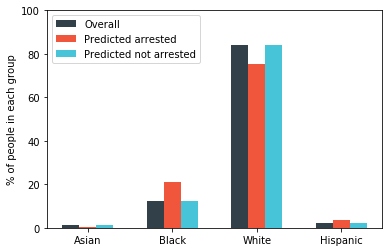

In [222]:
# Full DF
params = {'n_jobs': -1, 'n_estimators': 47, 'max_depth': 8, 'criterion': 'gini', 'class_weight': None}
weights = np.ones(clf_train_Y.shape[0])
weights[clf_train_Y==1] = 1.
weights[clf_train_Y==0] = 0.5
RFC = run_clf('RFC',train_latent_X,clf_train_Y,params,weights=weights)
bias = check_error_and_discrimination(RFC,test_latent_X,clf_test_Y,df_test,sensitive_features)
df_bias = pd.DataFrame(bias).transpose()
df_bias.columns = ["Group","N_group/N_total","N_group/N_total|(predicted arrest)","N_group/N_total|(predicted not arrest)"]
plot_distribution(df_bias)